In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from neurolib.models.wc import WCModel
from neurolib.control.optimal_control.oc_wc import OcWc
import matplotlib.pyplot as plt

# Oscillating Target

In [4]:
def get_oscillating_input(duration=10.0, amplitude=1.0, period=2.5):
    # We import the model
    model = WCModel()
    dt = model.params["dt"]

    # We define a "zero-input", and a sine-input
    input = np.zeros((1, round(duration / dt)))
    input[0, :] = amplitude * np.sin(2.0 * np.pi * np.arange(0, duration, dt) / period)# other functions or random values can be used as well
    zero_input = np.zeros_like(input)

    # We set the duration of the simulation and the initial values
    model.params["duration"] = duration
    x_init = 0.011225367461896877
    y_init = 0.013126741089502588
    model.params["exc_init"] = np.array([[x_init]])
    model.params["inh_init"] = np.array([[y_init]])

    # We set the stimulus in x and y variables, and run the simulation
    model.params["exc_ext"] = input
    model.params["inh_ext"] = zero_input
    model.run()

    # Define the result of the stimulation as target
    target = np.concatenate(
        (
            np.concatenate((model.params["exc_init"], model.params["inh_init"]), axis=1)[:, :, np.newaxis],
            np.stack((model.exc, model.inh), axis=1),
        ),
        axis=2,
    )
    # Remove stimuli and re-run the simulation
    model.params["exc_ext"] = zero_input
    model.params["inh_ext"] = zero_input
    model.run()
    target_input = np.concatenate((input, zero_input), axis=0)[np.newaxis, :, :]

    return model, target, target_input

In [5]:
N_OPT_STEPS = 500

In [6]:
model, target, target_input = get_oscillating_input()
print(target.shape)

(1, 2, 101)


In [9]:
oc_wc = OcWc(
    model,
    target,
    print_array=np.arange(0, 1000, 10),
)

Optimal control with target time series


In [10]:
%%time
oc_wc.optimize(N_OPT_STEPS)

Compute control for a deterministic system
Cost in iteration 0: 0.00041409081952594514
Cost in iteration 10: 3.2624148498419925e-05
Cost in iteration 20: 1.6633415770167384e-05
Cost in iteration 30: 8.023037661078436e-06
Cost in iteration 40: 5.355833376452629e-06
Cost in iteration 50: 3.877281309845375e-06
Cost in iteration 60: 2.9292802884198494e-06
Cost in iteration 70: 2.3253332223023006e-06
Cost in iteration 80: 1.904007167138528e-06
Cost in iteration 90: 1.6182079771724702e-06
Cost in iteration 100: 1.3790339671898143e-06
Cost in iteration 110: 1.2057918584472781e-06
Cost in iteration 120: 1.070634335744124e-06
Cost in iteration 130: 9.616066573644755e-07
Cost in iteration 140: 8.724692503387485e-07
Cost in iteration 150: 7.998738642788783e-07
Cost in iteration 160: 7.307425320852026e-07
Cost in iteration 170: 6.759844101366076e-07
Cost in iteration 180: 6.260948647070168e-07
Cost in iteration 190: 5.838282098182143e-07
Cost in iteration 200: 5.445493438958019e-07
Cost in iterati

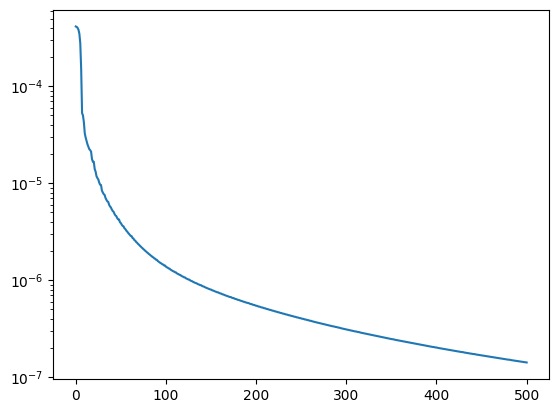

In [11]:
plt.plot(oc_wc.cost_history[:])
plt.yscale("log")

In [12]:
output = oc_wc.get_xs()

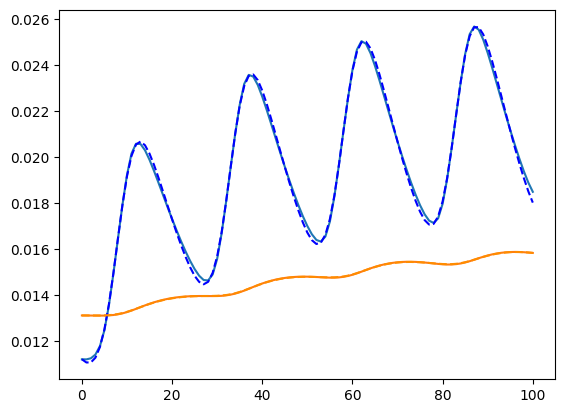

In [13]:
plt.plot(output[0, 0])
plt.plot(output[0, 1])
plt.plot(target[0, 0], linestyle="dashed", color="blue")
plt.plot(target[0, 1], linestyle="dashed", color="darkorange")

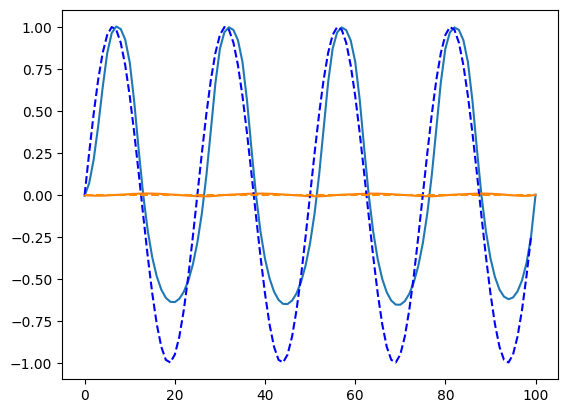

In [14]:
plt.plot(oc_wc.control[0,0])
plt.plot(oc_wc.control[0,1])
plt.plot(target_input[0, 0], linestyle="dashed", color="blue")
plt.plot(target_input[0, 1], linestyle="dashed", color="darkorange")

# Network Optimal Control

In [15]:
def get_network_model(duration=100.0, target="sync"):
    assert target in ("sync", "desync")
    if target == "sync":
        exc_ext_baseline = 1.6  # starts in desync
    elif target == "desync":
        exc_ext_baseline = 1.0  # starts in sync
    inh_ext_baseline = 0.4
    coupling = 0.8
    cmat = np.array(
        [
            [0.0, 1.0, 0.0, 0.0, 0.0, 1.0],
            [1.0, 0.0, 1.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
            [0.0, 0.0, 1.0, 0.0, 0.0, 1.0],
            [1.0, 1.0, 0.0, 1.0, 0.0, 1.0],
            [0.0, 1.0, 1.0, 0.0, 0.0, 0.0],
        ]
    )
    dmat = np.array(
        [
            [0.0, 12.0, 0.0, 0.0, 0.0, 8.0],
            [8.0, 0.0, 13.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 9.0],
            [0.0, 0.0, 4.0, 0.0, 0.0, 11.0],
            [5.0, 17.0, 0.0, 14.0, 0.0, 18.0],
            [0.0, 0.0, 3.0, 0.0, 0.0, 0.0],
        ]
    )

    model = WCModel(Cmat=cmat, Dmat=dmat)
    model.params["duration"] = duration
    model.params["K_gl"] = coupling
    model.params["exc_ext_baseline"] = exc_ext_baseline
    model.params["inh_ext_baseline"] = inh_ext_baseline
    if target == "sync":
        model.params["exc_init"] = np.array(
            [
                [
                    0.37629431,
                    0.3834639,
                    0.39003013,
                    0.39602553,
                    0.40148128,
                    0.40642708,
                    0.41089103,
                    0.41489965,
                    0.41847796,
                    0.4216496,
                ],
                [
                    0.07664943,
                    0.08165293,
                    0.08752262,
                    0.09441519,
                    0.1025122,
                    0.11201391,
                    0.12311931,
                    0.13598435,
                    0.1506553,
                    0.16699469,
                ],
                [
                    0.07875684,
                    0.07636045,
                    0.07407774,
                    0.07190517,
                    0.0698394,
                    0.06787725,
                    0.06601571,
                    0.06425192,
                    0.06258316,
                    0.06100687,
                ],
                [
                    0.44952161,
                    0.44716973,
                    0.44447951,
                    0.44142,
                    0.43795571,
                    0.43404647,
                    0.42964778,
                    0.42471168,
                    0.41918877,
                    0.41303149,
                ],
                [
                    0.21935044,
                    0.23761421,
                    0.25538914,
                    0.27241319,
                    0.28853971,
                    0.30370223,
                    0.31788527,
                    0.33110417,
                    0.34339215,
                    0.35479229,
                ],
                [
                    0.25446421,
                    0.24493458,
                    0.23571359,
                    0.22680549,
                    0.2182107,
                    0.20992683,
                    0.20194962,
                    0.19427347,
                    0.18689188,
                    0.17979782,
                ],
            ]
        )

        model.params["inh_init"] = np.array(
            [
                [
                    0.29211507,
                    0.30249908,
                    0.3124121,
                    0.32186336,
                    0.33086498,
                    0.33943103,
                    0.34757677,
                    0.35531816,
                    0.36267149,
                    0.36965306,
                ],
                [
                    0.10007338,
                    0.09902466,
                    0.09819244,
                    0.09762494,
                    0.09738978,
                    0.09758267,
                    0.0983393,
                    0.09984972,
                    0.10236971,
                    0.10621523,
                ],
                [
                    0.22296007,
                    0.21788133,
                    0.21291808,
                    0.20806914,
                    0.20333321,
                    0.19870887,
                    0.19419464,
                    0.18978898,
                    0.18549029,
                    0.18129693,
                ],
                [
                    0.45973146,
                    0.46165451,
                    0.46346183,
                    0.46515701,
                    0.46674288,
                    0.46822135,
                    0.46959324,
                    0.47085799,
                    0.47201328,
                    0.47305457,
                ],
                [
                    0.15372737,
                    0.16283135,
                    0.17347319,
                    0.18524034,
                    0.19771479,
                    0.21053877,
                    0.22343582,
                    0.23620594,
                    0.2487111,
                    0.26085994,
                ],
                [
                    0.44457159,
                    0.43947524,
                    0.43387474,
                    0.42783201,
                    0.42141133,
                    0.41467604,
                    0.40768612,
                    0.40049678,
                    0.39315779,
                    0.3857132,
                ],
            ]
        )

    model.run()

    return model

In [16]:
model = get_network_model()

In [17]:
N_OPT_STEPS = 500

In [20]:
oc_wc = OcWc(model,
             20.,
             print_array=np.arange(0, 1000, 10),
             )
oc_wc.weights["w_p"] = 0.0
oc_wc.weights["w_cc"] = 1.0
oc_wc.weights["w_2"] = 0.01

Optimal control with target oscillation period


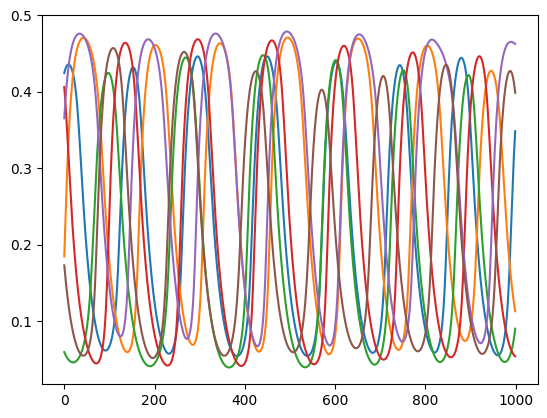

In [21]:
plt.plot(oc_wc.model.exc.T)

In [22]:
oc_wc.optimize(N_OPT_STEPS)

Compute control for a deterministic system
Cost in iteration 0: 0.1533793381985457
Cost in iteration 10: -1.6110351146447108
Cost in iteration 20: -1.7432932241227566
Cost in iteration 30: -1.7745980863742952
Cost in iteration 40: -1.7791561022074474
Cost in iteration 50: -1.780331291504654
Cost in iteration 60: -1.781368493945349
Cost in iteration 70: -1.7818936740225948
Cost in iteration 80: -1.782367393687795
Cost in iteration 90: -1.7828851830152486
Cost in iteration 100: -1.7833223417400048
Cost in iteration 110: -1.7836800631574736
Cost in iteration 120: -1.7839964071571526
Cost in iteration 130: -1.784260482598177
Cost in iteration 140: -1.7845732677905648
Cost in iteration 150: -1.7848615619686474
Cost in iteration 160: -1.7850971713323955
Cost in iteration 170: -1.785347802669686
Cost in iteration 180: -1.7856285209666003
Cost in iteration 190: -1.7858881424502386
Cost in iteration 200: -1.7861026626454979
Cost in iteration 210: -1.7863309532509468
Cost in iteration 220: -1.78

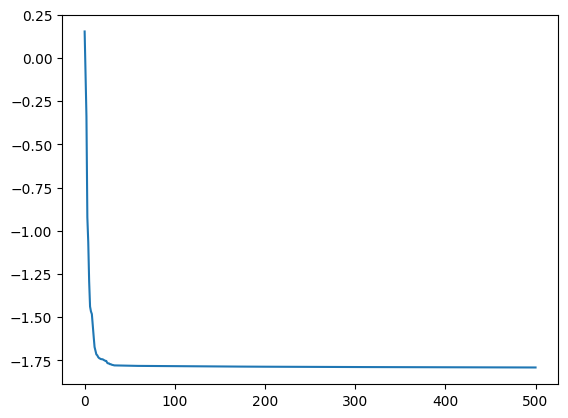

In [23]:
plt.plot(oc_wc.cost_history)

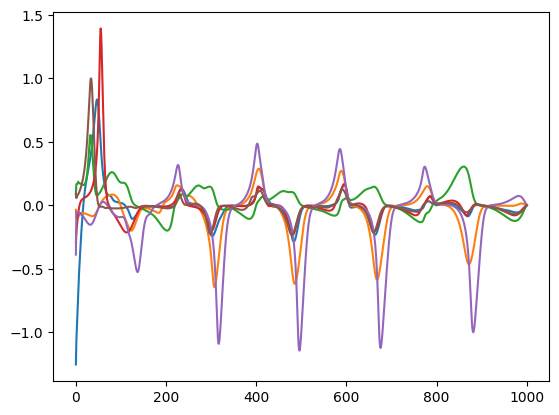

In [25]:
plt.plot(oc_wc.control[:,0].T)

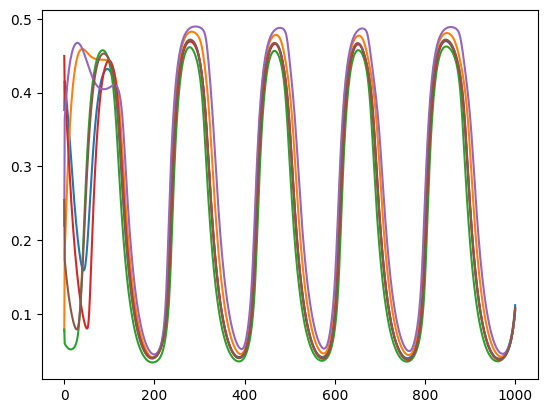

In [27]:
output = oc_wc.get_xs()
plt.plot(output[:,0].T)

### Desync Task

In [28]:
model = get_network_model(target="desync")

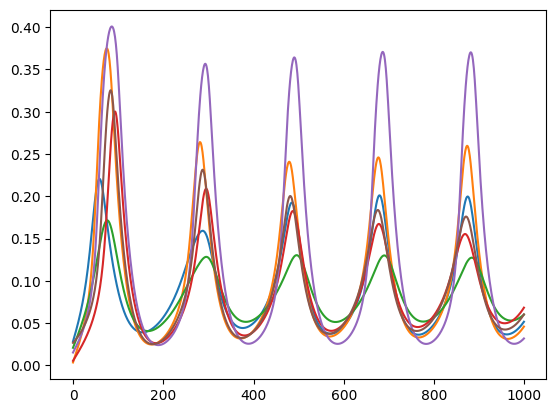

In [29]:
plt.plot(model.exc.T)

In [30]:
oc_wc = OcWc(model, 20., print_array=np.arange(0, 1000, 10))
oc_wc.weights["w_p"] = 0.0
oc_wc.weights["w_cc"] = -1.0
oc_wc.weights["w_2"] = 0.01

Optimal control with target oscillation period


In [31]:
oc_wc.optimize(N_OPT_STEPS)

Compute control for a deterministic system
Cost in iteration 0: 1.7539681168121604
Cost in iteration 10: -0.05504538712447907
Cost in iteration 20: -0.21256840950703174
Cost in iteration 30: -0.23693376642748387
Cost in iteration 40: -0.24836384877181708
Cost in iteration 50: -0.2568012246004818
Cost in iteration 60: -0.26237723519755546
Cost in iteration 70: -0.26709682011701785
Cost in iteration 80: -0.2714116003691076
Cost in iteration 90: -0.2745649279504049
Cost in iteration 100: -0.2771507734874647
Cost in iteration 110: -0.2792740304530489
Cost in iteration 120: -0.2814641221248433
Cost in iteration 130: -0.28342443839308185
Cost in iteration 140: -0.28521712791555764
Cost in iteration 150: -0.2865656386749644
Cost in iteration 160: -0.2880455925067884
Cost in iteration 170: -0.2892170329300595
Cost in iteration 180: -0.2904074733489331
Cost in iteration 190: -0.29142759356851616
Cost in iteration 200: -0.2923625345807418
Cost in iteration 210: -0.29322103325990695
Cost in itera

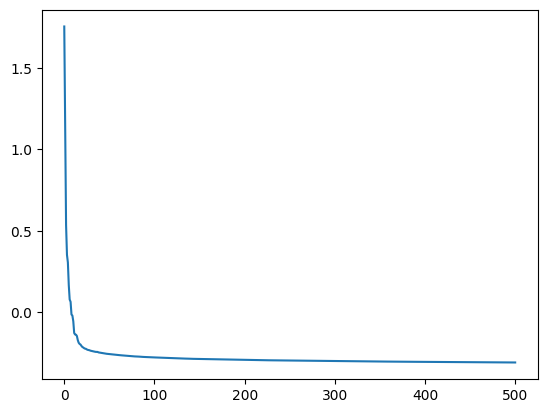

In [32]:
plt.plot(oc_wc.cost_history)

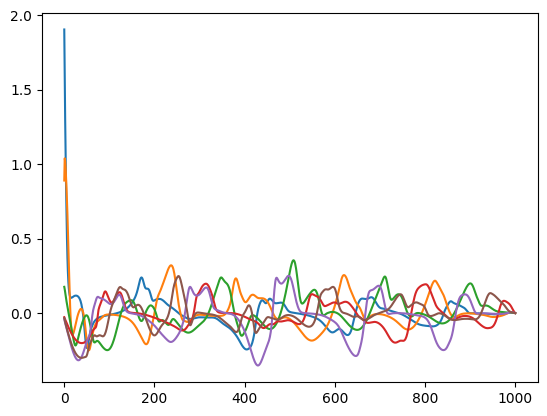

In [33]:
plt.plot(oc_wc.control[:,0].T)

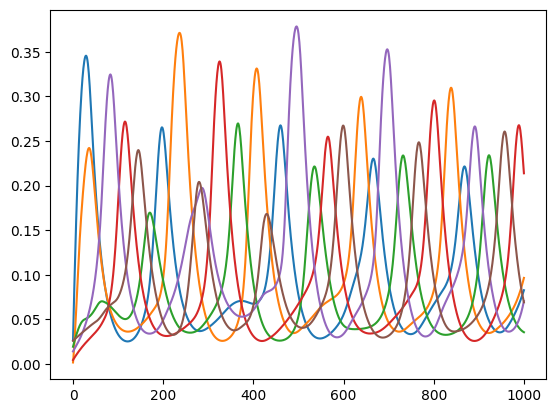

In [34]:
output = oc_wc.get_xs()
plt.plot(output[:,0].T)